# 使用 MNIST 数据集来学习分类

本文内容是对 [Hands-on Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do) 这本书的第三章的实践。

首先先下载数据集，通过网络下速度极慢，可以去下面指定的链接下载对应文件，然后放到 `~/$HOME/scikit_learn_data/mldata/` 目录下。

In [2]:
from sklearn.datasets import fetch_mldata

# https://raw.githubusercontent.com/amplab/datascience-sp14/master/lab7/mldata/mnist-original.mat
mnist = fetch_mldata('MNIST original')

In [3]:
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [4]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

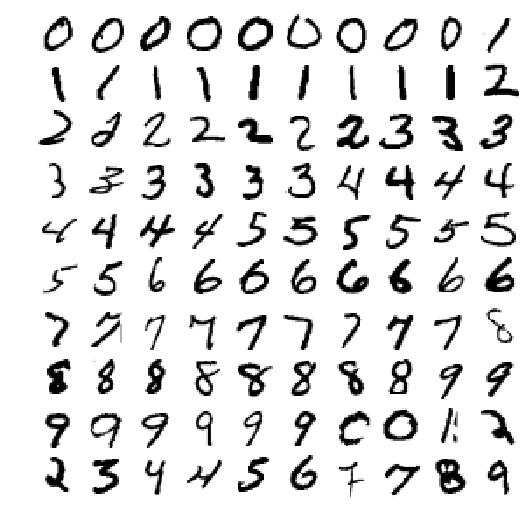

In [104]:
import matplotlib

# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
example_images = X[0:70000:700]
plot_digits(example_images, images_per_row=10)

In [5]:
import numpy as np

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 把训练集的顺序打乱，防止同种标签的样本连续出现
shuffle_index = np.random.permutation(60000)
X_train = X_train[shuffle_index]
y_train = y_train[shuffle_index]

## 训练二分类分类器

训练一个二分类分类器，用来区分 5 和其他数字。

In [6]:
# 改变标签

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

对于 SGDClassifier，需要确定它的迭代次数，但是往往事先并不知道需要迭代多少次。

一种方法是设置参数 tol，即 tolerance，两次迭代错误率提高量低于 tol 时停止，为了避免迭代次数过多，可以设置 `max_iter` 参数，限制最大迭代次数。

In [35]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, n_iter=50)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

## 测试分类器性能

### 使用交叉验证来测试性能

`StratifiedKFold` 这个类可以用来产生每一折的训练集和验证集的下标，由此可以得出训练集和验证集

In [25]:
# 实现交叉验证

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, random_state=42)

for train_index, validate_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_validata_folds = X_train[validate_index]
    y_validate_folds = y_train_5[validate_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_validata_folds)
    
    n_correct = sum(y_pred == y_validate_folds)
    print(n_correct / len(y_validate_folds))
    

0.9639196733605533
0.9708333333333333
0.9726666666666667
0.96875
0.9694974581215101


实际项目中可以使用 sklearn 中的 cross_val_score 来进行交叉验证，并计算精度。

In [26]:
# 使用 cross_val_score 来完成交叉验证

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.96391967, 0.97083333, 0.97266667, 0.96875   , 0.96949746])

准确度，表示所有样本中，被预测正确的样本的占比，这里 accuracy 达到了 97% 左右，看似很喜人的结果，但事实并非如此。

因为样本中正例（数字5）和反例（非数字5）的比例是 1:9，因此分类器只需要对对所有样本均输出 0（认为待预测样本不是数字5），也能得到 90% 的准确度。所以在这个场景下精度，就没有很大的意义。
    
精度在分类问题中往往不能很好地体现分类器的性能，尤其是在样本分布不均匀的情况下。

### 使用 confusion matrix

confusion matrix 用来观察分类的具体细节，能够看出各个类别样本都被分到了那些类别，以及占比如何。因此，需要对某些样本进行预测，并与其真实的标签对比。

这里一种方法是使用测试数据，但通常测试数据不应该参与到模型的选择中，测试数据只应该用于模型确定之后，来估计泛化误差。

可以在交叉验证中对训练集进行预测，并与训练集的样本标签比较。因为在交叉验证中，一部分训练集被抽出来作为验证集，因此交叉验证的每一折，都可以得出部分训练集的预测结果。

In [30]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)


from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53985,   594],
       [ 1258,  4163]])

confusion matrix 中第 n 行 m 列的元素，表示第 n 类被预测为第 m 类的数量。因此对角线上的元素越大越好，非对角线上的元素越接近 0 越好。

### 精度和召回率 / precision and recall

这里的精度和前面的 accuracy 不同，**precision** 表示在预测为真的样本中，实际确实为真的样本的占比。因此，如果要提高 precision，可以只对那些有非常大的把握认为是正例的样本预测为正。要追求高精度，也就是强调结果的可靠性、准确性。可以漏掉一些正例，但一旦认为某些样本是正例，那就得有很大把握才是。

**召回率**表示预测结果中，预测正确的正例占所有正例的比例。即所有正例中有多少被真真切切地找出来了，指被预测为正的正例占所有正例的比例。为了提高召回率，可以认为所有样本都是正例，这样召回率就为1，不过此时精度也就下降了，因为有大量不是正例的样本被认为是正例。


```
precision = TP / (TP + FP)

recall = TP / (TP + FN)
```


可以看出，实际项目中在 precision 和 recall 之间需要权衡，两者中一个升高，另一个就要降低。


```
F1 = 2 * precision * recall / (precision + recall)
```

F1 是将 precision 和 recall 综合起来的指标，只有两者 precision 和 recall 都具有较大的值时，F1 的值才会大。

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

(
precision_score(y_train_5, y_train_pred),
recall_score(y_train_5, y_train_pred),
f1_score(y_train_5, y_train_pred)
)

(0.8751313853268867, 0.7679394945581995, 0.8180389074474355)

某些时候，希望预测结果能有较高的 precision 或者 recall，这需要改变分类器给样本分类的策略，通常分类器是根据每个样本的 confidence scores 和一个 threshold 来决定它的分类的，
即当 confidence scores > threshold 是一类，否则是另一类。调整这个 threshold 便可以调整预测结果的 precision 和 recall。

比如提高 threshold 意味着分类器十分确信的时候，才会将样本分为正例，这样就可以提高 precision。

要设置这个 threshold 需要知道相应的 threshold 对应的 precision 和 recall。一个方法是让分类器返回对各个样本的 confidence scores，知道了 confidence scores 以及各样本的标签，就可以知道各个 threshold 对应的 precision 和 recall 了。

In [36]:
# 调用分类器上的 decision_function 可以返回 confidence scores

y_scores = sgd_clf.decision_function(X_train[0:10])
y_scores

array([-47044.91304994, -71559.42305145,   7627.2811094 , -32457.57396719,
        -8391.70456837, -39278.16271114, -17526.92587301, -85131.77679098,
       -30010.75209221, -40600.72563102])

In [38]:
# 可以使用交叉验证来对训练集各个样的预测 confidence scores 

# 这里 method 参数是指在传入的 estimator 上调用该方法，这里需要返回样本的 confidence scores 因此传入 "decision_function"
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5, method="decision_function")

利用各个样本的 confidence scores 和 标签，可以使用 `precision_recall_curve` 这个函数来得出各个 threshold 下的 recall 和 precision

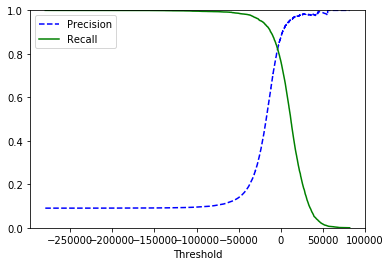

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve


precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# >>> (precisions.shape, recalls.shape, thresholds.shape)
# <<< ((59982,), (59982,), (59981,)) thresholds 少一个维度
#
# 需要注意的是 `precision_recall_curve` 这个函数返回三个值，分别为 `precisions`, `recalls`, `thresholds`，
# 其中 `thresholds` 较 `precisions` 和 `recalls` 要短 1。


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel('Threshold')
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

这样以来就可以更具图像，找出 threshold，比如需要 recall 达到 90%，那么 threshold 大概需要为 -10000。因此可以将 confidence scores 大于 -10000 的样本的标签设为 1。

In [57]:
y_train_pred_recall_90 = (y_scores > -10000)

{
    'precision': precision_score(y_train_5, y_train_pred_recall_90),
    'recall': recall_score(y_train_5, y_train_pred_recall_90)
}

{'precision': 0.6868398515558093, 'recall': 0.8876591034864416}

precision 和 recall 之间存在一个权衡，需要综合考虑实际需要，来选取合适的 threshold。


也可以直接画出 precisions 和 recalls 的变化关系：

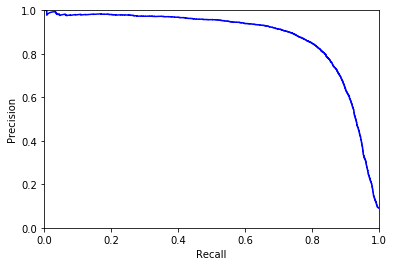

In [60]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", label="Precision")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plot_precision_vs_recall(precisions, recalls)

通过这个曲线，可以看出某个 recall 对应的 precision，以此来进行两者的权衡。

### ROC 曲线

要想提高召回率，就要以分错部分正例为代价，ROC 曲线能够反映出召回率的上升和错分正例比率的关系。如果这条曲线与纵轴贴的很近，那说明不需要出现太多对正例的错分，就能得到不错的召回率。

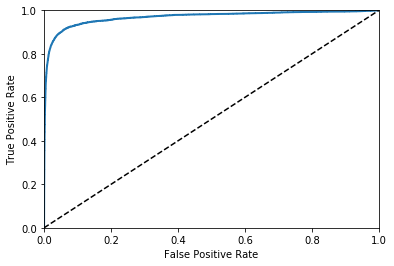

In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)

这条蓝色的曲线下所包围的面积越大，表明曲线与左上角越贴近，分类器的效果也就越好。可以使用 `roc_auc_score` 来计算 area under the curve。

In [63]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9684540576444214

这里使用 `RandomForestClassifier` 来做分类，与 SGD 对比一下 roc 曲线

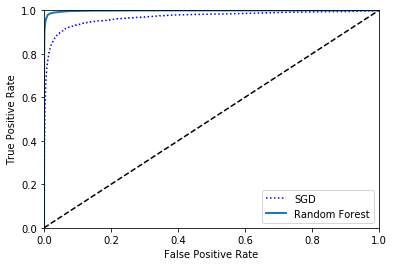

In [66]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=5, method='predict_proba')

y_scores_forest = y_probas_forest[:,1]
fpr_forset, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forset, tpr_forest, label="Random Forest",)
plt.legend(loc='lower right')

0.9984331812040864

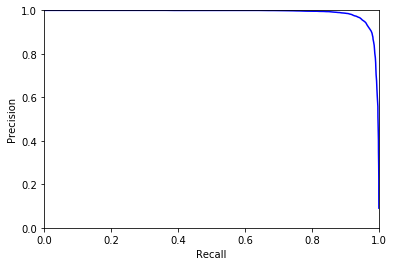

In [78]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plot_precision_vs_recall(precisions_forest, recalls_forest)

roc_auc_score(y_train_5, y_scores_forest)

可以看到 roc_auc 达到了 99.84%，且 precision 和 recall 曲线更加贴近右上角，分类取得了不错的效果。如果去 recall 为 90%，那么精度也能达到 95% 以上。

## 多分类

多分类任务，可以使用二分类分类器来完成，通过采用 1对多 或者 1对1 的策略训练多个分类器，组合成多分类器。

对于 N 分类任务，如果采用 1对1 的策略，需要训练 N(N-1) 也分类器，但是每次训练只在两类样本上进行，训练的速度会更快。而 1对多，需要训练 N 个分类器，但每次都是在全部样本上来进行的，训练速度常常慢于 1对1。

在 Scikit-Learn 中，如果使用二分类器来进行多分类，除了 SVM 外，会自动使用 1对多的策略。

如果要强制使用某种策略，可以使用  `OneVsOneClassifier` 或者 `OneVsRestClassifier` 这两个类：

In [81]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, n_iter=5))

ovo_clf.fit(X_train,y_train)

len(ovo_clf.estimators_)

45

可以看到使用 1对1 的策略，一共训练了 `10*9=45` 个分类器来完成分类任务。

对于随机森林分类器，它本身就可以处理多分类任务，所以无需采用 1对1 或者 1对多 的策略。

In [86]:
forest_clf.fit(X_train, y_train)

(forest_clf.predict_proba([X_train[1]]), y_train[1])

(array([[0.  , 0.  , 0.  , 0.  , 0.95, 0.01, 0.  , 0.02, 0.  , 0.02]]), 4.0)

在随机森林分类器上调用 `predict_proba` 可以得出对某个样本在各个类别上的概率。上面给出的样本是 4 ，而预测结果显示样本属于第 4 类的概率为 95%。

In [89]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring='accuracy')

array([0.86305706, 0.86060657, 0.83983333, 0.87980328, 0.87620874])

有时候将样本做一些预处理，能够很容易地提升准确率。这是因为手写数字图片中数字的颜色深浅不同，将其做标准化后，可以在一定程度上消除这些影响。`StandardScaler` 的做法是将样本的各个维度减去均值，然后除以标准差。

In [90]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')

array([0.91162016, 0.91334778, 0.91283333, 0.91272818, 0.91147049])

### 错误分析

In [94]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=5)

使用 confusion matrix 对多分类器的分类的结果进行分析，可以看出容易分错的样本类型，并采取合理的手段来改进。

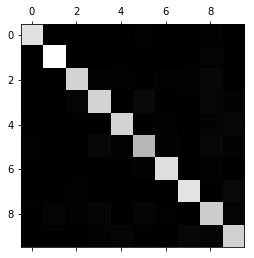

In [97]:
conf_mat = confusion_matrix(y_train, y_train_pred)

plt.matshow(conf_mat, cmap=plt.cm.gray)

将 confusion matrix 绘成图方便查看，从中可以看到，主对角线上呈亮白色，说明大部分样本都分类正确了。为了观察分类错误的样本，需要让主对角线以外的块能够显示的更明显一些。

具体的做法是求出每个块在该行的占比，即某个类别分其他各类的比重，然后将主对角置零，如此以来就能明显地看到错分的情况了。

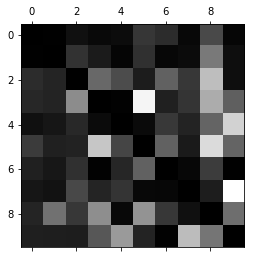

In [100]:
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat / row_sums

np.fill_diagonal(norm_conf_mat, 0)

plt.matshow(norm_conf_mat, cmap=plt.cm.gray)

从上图能够看到 `5->3`, `3->5`, `7->9`, `5->8` 这几些类别间错分的情况比较严重。

把数字3和5的图片挑出来一部分，进行观察：

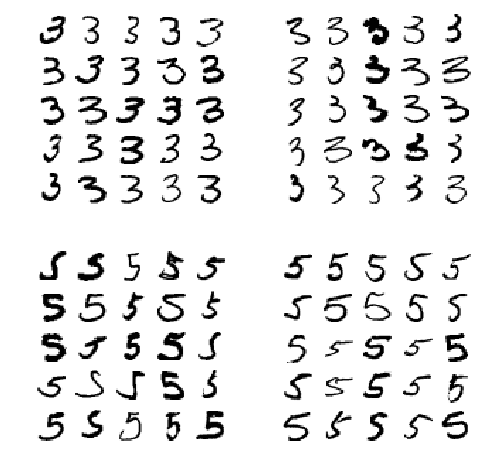

In [105]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

其中副对角线上位为错分的图片，可以看出他们还是有很明显的特征的，但是分错了。这是因为这里采用了很简答的 SGD 分类器，这个分类器就是简单地对各个像素点上的值进行了一个线性加权求和，然后使用梯度下降的方法求合适的权重。这个模型采用的提取特征的方式太简陋，因此面对 3 和 5 这样的在像素点分布差不太多的类别时，就会出错。

采用其他能够更好地提取特征的模型，可能能够提升分类效果。

## 使用 KNeighborsClassifier 分类器

使用 KNN 可以得到不错的分类结果，该分类器的思想是寻找和样本最相近的 K 个样本，然后使用这 K 个样本的类别来决定分类结果。主要问题是这个模型，在做出预测的过程中太慢了，下面模型在32核机器上跑了 10 多分钟才结束，如果使用 `GridSearchCV` 来搜索最佳参数，不知要跑到何年何月，没必要为此消耗电能。

In [108]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance')

param_grid = [
    {"n_neighbors": [4]}
]
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='distance'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_neighbors': [4]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

KNeighborsClassifier 实在是太慢了，这也比较好理解，它需要在预测阶段和所有样本计算距离，不知道在计算距离这一步有没有采用什么高效的手段。

In [110]:
# 得到最佳的参数
grid_search.best_params_

# 得到最佳的分类器
grid_search.best_estimator_

# 最佳分数（此处为 accuracy）
grid_search.best_score_

0.9710666666666666

In [111]:
from sklearn.metrics import accuracy_score

y_test_pred = grid_search.predict(X_test)

accuracy_score(y_test, y_test_pred)

0.9714

KNeighborsClassifier 分类器确实取得了不俗的效果。